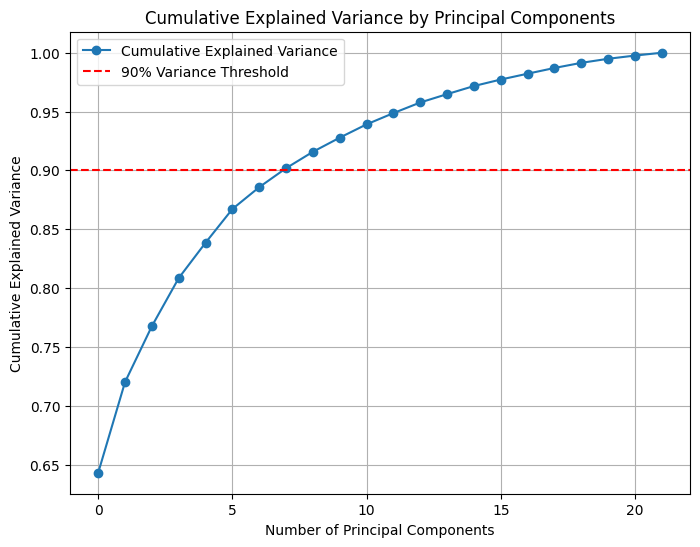

Số lượng thành phần chính được chọn: 8
Optimization terminated successfully.
         Current function value: 0.393065
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103895
Method:                           MLE   Df Model:                            8
Date:                Fri, 03 Jan 2025   Pseudo R-squ.:                  0.4255
Time:                        17:03:19   Log-Likelihood:                -40841.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5103      0.009    -55.077      0.000      -0.528   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

# Load the dataset
file_path = 'Airplane1.csv'  # Update with the actual path
df = pd.read_csv(file_path)

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'id'], errors='ignore')

# kiem tra nall
for col in df.columns:
    nan_col = df[col].isna().sum() 
    if nan_col > 0:
        if nan_col/len(df)>0.2:
            df = df.drop(columns=col)
        else:
            df =df.fillna(df[col].mean())


# Encode categorical data using OrdinalEncoder
encoder = OrdinalEncoder()
df_encoded = encoder.fit_transform(df)
df_encoded = pd.DataFrame(df_encoded, columns=df.columns)

# Separate features and target
X = df_encoded.drop(columns=['satisfaction'])
y = df_encoded['satisfaction']

# Scale the features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumsum_explained_var = np.cumsum(explained_var)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumsum_explained_var, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.legend()
plt.grid()
plt.show()

# Select number of components
n_components = np.argmax(cumsum_explained_var >= 0.9) + 1
print(f'Số lượng thành phần chính được chọn: {n_components}')

# Apply PCA with selected components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# Logistic regression with statsmodels
X_with_const = sm.add_constant(X_pca_reduced)
logit_model = Logit(y, X_with_const).fit()
print(logit_model.summary())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Logistic regression with sklearn
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Intercept and coefficients
intercept = model.intercept_
coefficients = model.coef_
print(f'Hệ số chặn (Intercept): {intercept}')
print(f'Hệ số hồi quy (Coefficients): {coefficients}')

# Predictions and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print('Độ chính xác (Accuracy):', accuracy)
print('Báo cáo phân loại (Classification Report):\n', classification_rep)
